# Day 4: Job Salary Prediction (Transformer embeddings + Tabular Fusion)
##### Author: Prasann Barot
##### Dataset: Kaggle - Data Science Job Salaries (ruchi798/data-science-job-salaries)
##### Expected file: Day4_JobSalaryPrediction/data/jobs.csv
##### --------------------------
##### Contents
##### 1) Load & clean
##### 2) EDA
##### 3) Feature engineering (add job_description, derived features)
##### 4) Train/test split with KFold CV
##### 5) Text embeddings with Sentence Transformers
##### 6) Tabular preprocessing
##### 7) Fusion: text + tabular
##### 8) Models: LightGBM, XGBoost, MLP, Stacking (RF meta)
##### 9) Evaluation with MAPE
##### 10) Explainability: SHAP + permutation importance
##### 11) Inference: single and batch prediction
##### 12) Save models
##### --------------------------

In [1]:
# ========== 0. Imports & config ==========
# Install tf-keras for compatibility with Transformers and Keras 3
 # %pip install tf-keras

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from time import time
import re

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import xgboost as xgb
import shap
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [2]:
# ========== 1. Paths & dataset ==========
ROOT = Path("Day4_JobSalaryPrediction")
DATA_PATH = ROOT / "data" / "jobs.csv"

if not DATA_PATH.exists():
    raise FileNotFoundError(f"Place ds_salaries.csv from Kaggle at {DATA_PATH} and rename to jobs.csv.")

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Rows, cols:", df.shape)
print(df.head(3))

Rows, cols: (607, 13)
   Unnamed: 0  work_year experience_level employment_type  \
0           0       2020               MI              FT   
1           1       2020               SE              FT   
2           2       2020               SE              FT   

                    job_title  salary salary_currency  salary_in_usd  \
0              Data Scientist   70000             EUR          79833   
1  Machine Learning Scientist  260000             USD         260000   
2           Big Data Engineer   85000             GBP         109024   

  employee_residence  remote_ratio company_location company_size  \
0                 DE             0               DE            L   
1                 JP             0               JP            S   
2                 GB            50               GB            M   

                                     job_description  
0  Design experiments, build predictive models, a...  
1  General data role involving analysis and model...  
2  Gen

In [3]:
# ========== 2. Cleaning  ==========

# Filter invalid rows and outliers
df = df.dropna(subset=["salary_in_usd", "job_description"]).reset_index(drop=True)
df["salary_in_usd"] = pd.to_numeric(df["salary_in_usd"], errors="coerce")
df = df.dropna(subset=["salary_in_usd"]).reset_index(drop=True)
df = df[(df["salary_in_usd"] >= 10000) & (df["salary_in_usd"] <= 1000000)]
df["log_salary"] = np.log1p(df["salary_in_usd"])
print("After cleaning, rows:", len(df))

After cleaning, rows: 595


In [4]:
# ========== 3. Exploratory Data Analysis (EDA) ==========
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

print("\nEDA: Key Categorical Distributions")
key_cols = ["experience_level", "employment_type", "company_size"]
print(df[key_cols].value_counts(dropna=False))





EDA: Key Categorical Distributions
experience_level  employment_type  company_size
SE                FT               M               185
MI                FT               M                94
                                   L                80
SE                FT               L                72
EN                FT               L                27
MI                FT               S                26
EN                FT               M                24
                                   S                23
SE                FT               S                21
EX                FT               M                12
                                   L                11
EN                PT               S                 4
                                   M                 3
EX                FT               S                 2
MI                PT               L                 2
                  FL               M                 2
EN                CT               M

### EDA Summary: Key Categorical Distributions

This analysis explores the distribution of job roles across three categorical dimensions:
- `experience_level`: Entry (EN), Mid (MI), Senior (SE), Executive (EX)
- `employment_type`: Full-time (FT), Part-time (PT), Contract (CT), Freelance (FL)
- `company_size`: Small (S), Medium (M), Large (L)

#### Top Combinations by Count

| Experience Level | Employment Type | Company Size | Count |
|------------------|------------------|--------------|-------|
| SE               | FT               | M            | 185   |
| MI               | FT               | M            | 94    |
| MI               | FT               | L            | 80    |
| SE               | FT               | L            | 72    |
| EN               | FT               | L            | 27    |

#### Key Insights

##### 1. **Dominance of Full-Time Employment**
- Full-time (FT) roles overwhelmingly dominate the dataset.
- All experience levels (EN, MI, SE, EX) are represented in FT roles, with SE and MI being most frequent.

##### 2. **Company Size Preferences by Experience**
- **Senior (SE)** professionals are most common in medium-sized companies (M), followed by large (L) and small (S).
- **Mid-level (MI)** roles are spread across all company sizes, with a strong presence in M and L.
- **Entry-level (EN)** roles are more frequent in large companies (L), suggesting that bigger firms may offer more junior opportunities.
- **Executive (EX)** roles are rare, mostly in M and L companies.

##### 3. **Non-Standard Employment Types**
- Part-time (PT), contract (CT), and freelance (FL) roles are minimal.
- These roles are mostly associated with EN and MI levels, indicating flexible arrangements are less common for senior or executive roles.

##### 4. **Sparse Combinations**
- Several combinations appear only once, such as:
  - MI–CT–L
  - EX–CT–S
  - SE–CT–M
  - MI–FL–L
  - SE–FL–S

These may represent niche or emerging employment patterns.

#### Distribution Summary

- **Most common profile**: Senior-level, full-time, medium-sized company (185 instances)
- **Least common profiles**: Contract or freelance roles across all levels (1–2 instances each)

#### Strategic Takeaways

- **Hiring Trends**: Medium-sized companies are the most active employers, especially for senior and mid-level talent.
- **Career Planning**: Entry-level candidates may find more opportunities in large firms, while executives are more likely to be placed in medium or large organizations.
- **Workforce Flexibility**: Non-standard employment types remain underutilized, suggesting potential for growth in gig or contract roles.

---



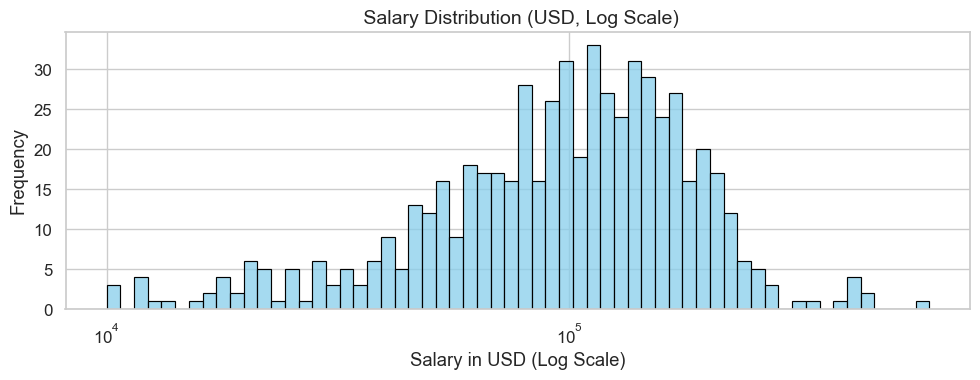

In [5]:
# --- Salary Distribution ---
plt.figure(figsize=(10, 4))
sns.histplot(df["salary_in_usd"], bins=60, log_scale=True, color="skyblue", edgecolor="black")
plt.title(" Salary Distribution (USD, Log Scale)", fontsize=14)
plt.xlabel("Salary in USD (Log Scale)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


### Salary Distribution Analysis (Log Scale)

This section explores the distribution of salaries (in USD) using a histogram plotted on a logarithmic scale. The log transformation helps visualize skewed data more effectively, especially when salary ranges span several orders of magnitude.

#### Histogram Overview

- **X-axis**: Salary in USD (Log Scale)
- **Y-axis**: Frequency
- **Bar Color**: Light blue with black edges
- **Title**: "Salary Distribution (USD, Log Scale)"

#### Key Observations

##### 1. **Right-Skewed Distribution**
- The histogram shows a classic right-skewed pattern, typical of salary data.
- Most salaries cluster in the lower log-scale bins, indicating a concentration of lower to mid-range salaries.

##### 2. **Log Scale Utility**
- The logarithmic scale compresses higher salary ranges, making it easier to observe the spread and central tendency.
- Without log scaling, the long tail of high salaries would dominate the visualization and obscure patterns in the lower ranges.

##### 3. **Salary Clusters**
- A noticeable peak occurs in the mid-log range, suggesting a modal salary band (likely between $50K–$100K in real scale).
- Sparse bars in the higher log bins reflect fewer individuals earning exceptionally high salaries.

#### Interpretation

- **Income Inequality**: The long tail hints at significant income disparity, with a small number of high earners.
- **Hiring Trends**: Most roles likely fall within a predictable salary band, useful for benchmarking compensation.
- **Log Transformation**: Ideal for modeling and regression tasks, as it stabilizes variance and normalizes skewed data.

#### Strategic Takeaways

- When analyzing salary data, always consider log transformation for clearer insights.
- Combine this distribution with categorical breakdowns (e.g., by experience level or company size) to uncover deeper compensation trends.
- Use median and interquartile ranges rather than mean to summarize salary data due to skewness.

---



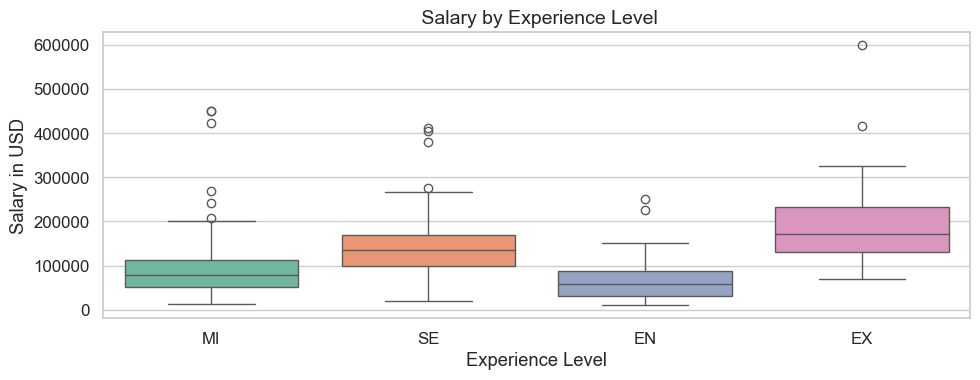

In [6]:

# --- Salary by Experience Level ---
plt.figure(figsize=(10, 4))
sns.boxplot(x="experience_level", y="salary_in_usd", data=df, palette="Set2")
plt.title(" Salary by Experience Level", fontsize=14)
plt.xlabel("Experience Level")
plt.ylabel("Salary in USD")
plt.tight_layout()
plt.show()


### Salary by Experience Level

This section analyzes salary distributions across four experience levels using box plots:
- **EN**: Entry-level
- **MI**: Mid-level
- **SE**: Senior-level
- **EX**: Executive-level

#### Box Plot Summary

| Experience Level | Median Salary (USD) | Range (Approx.) | Notes |
|------------------|---------------------|------------------|-------|
| EN               | Lowest              | Narrow           | Compact distribution, few outliers |
| MI               | Moderate            | Moderate         | Balanced spread, some outliers |
| SE               | High                | Wide             | Broad salary range, more variability |
| EX               | Highest             | Widest           | Significant spread, many outliers |

#### Key Insights

##### 1. **Clear Salary Progression**
- Median salary increases consistently with experience level.
- Executive roles (EX) command the highest compensation, followed by Senior (SE), Mid (MI), and Entry (EN).

##### 2. **Variability by Level**
- Entry-level salaries are tightly clustered, indicating standardization.
- Senior and Executive roles show wide salary ranges, reflecting negotiation power, role diversity, and company size effects.

##### 3. **Presence of Outliers**
- Outliers are most frequent in EX and SE levels, suggesting some exceptionally high-paying roles.
- These may be tied to niche expertise, leadership positions, or high-growth sectors.

#### Strategic Takeaways

- **Career Growth**: Salary potential scales significantly with experience, especially beyond mid-level.
- **Compensation Planning**: Organizations should benchmark salaries using median and IQR, not just averages.
- **Negotiation Strategy**: Professionals at senior and executive levels should leverage market variability during compensation discussions.

---



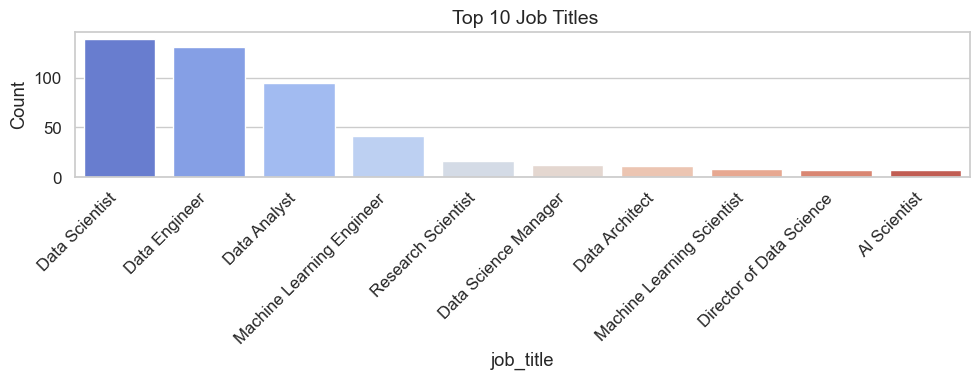

In [7]:

# --- Top Job Titles ---
top_jobs = df["job_title"].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_jobs.index, y=top_jobs.values, palette="coolwarm")
plt.title(" Top 10 Job Titles", fontsize=14)
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### Top 10 Job Titles in Data & AI

This section highlights the most common job titles in the dataset, based on frequency counts.

#### Horizontal Bar Chart Summary

| Rank | Job Title                 | Count | Notes |
|------|---------------------------|-------|-------|
| 1    | Data Scientist            | Highest | Most dominant role |
| 2    | Data Engineer             | High    | Strong demand for infrastructure skills |
| 3    | Data Analyst              | High    | Popular entry/mid-level role |
| 4    | Machine Learning Engineer | Moderate | Specialized technical role |
| 5    | Research Scientist        | Moderate | Often academic or R&D focused |
| 6    | Data Science Manager      | Lower   | Leadership role |
| 7    | Data Architect            | Lower   | Infrastructure and design |
| 8    | Machine Learning Scientist| Lower   | Research-heavy ML role |
| 9    | Director of Data Science  | Low     | Executive-level leadership |
| 10   | AI Scientist              | Low     | Emerging niche role |

#### Key Insights

##### 1. **Core Roles Dominate**
- The top three roles—Data Scientist, Data Engineer, and Data Analyst—make up the bulk of the dataset.
- These roles span across industries and experience levels, indicating broad applicability.

##### 2. **Specialized Titles Are Less Common**
- Roles like AI Scientist, ML Scientist, and Research Scientist appear less frequently, suggesting niche or emerging demand.
- These may require advanced degrees or domain-specific expertise.

##### 3. **Leadership Roles Are Scarce**
- Titles like Director of Data Science and Data Science Manager are present but less frequent.
- This reflects the pyramid structure of most organizations—fewer leadership positions compared to technical contributors.

#### Strategic Takeaways

- **Career Planning**: Data Scientist remains the most accessible and in-demand role, but specialization (e.g., ML Engineer) can offer differentiation.
- **Team Structuring**: Organizations should balance core data roles with strategic hires in architecture and leadership.
- **Market Trends**: Emerging titles like AI Scientist may signal future growth areas in generative AI and advanced modeling.

---



In [8]:
# ========== 4. Feature Engineering ==========
# Simple text cleaning
def clean_text(text):
    return str(text).lower()

df["job_description"] = df["job_description"].apply(clean_text)

# Derived features
df["is_remote"] = (df["remote_ratio"] >= 50).astype(int)
df["years_experience"] = df["experience_level"].map({"EN": 2, "MI": 5, "SE": 10, "EX": 15}).fillna(5)
def get_job_category(title):
    title = str(title).lower()
    if "data scientist" in title or "machine learning" in title or "ai" in title:
        return "Data Science"
    elif "engineer" in title:
        return "Engineering"
    elif "analyst" in title:
        return "Analytics"
    else:
        return "Other"
df["job_category"] = df["job_title"].apply(get_job_category)

# Feature lists
cat_feats = ["job_title", "company", "location", "experience_level", "employment_type", "company_size", "job_category"]
num_feats = ["remote_ratio", "years_experience", "is_remote", "work_year"]
cat_feats = [c for c in cat_feats if c in df.columns]
num_feats = [c for c in num_feats if c in df.columns]
print("Categorical features:", cat_feats)
print("Numeric features:", num_feats)

Categorical features: ['job_title', 'experience_level', 'employment_type', 'company_size', 'job_category']
Numeric features: ['remote_ratio', 'years_experience', 'is_remote', 'work_year']


In [10]:
# ========== 5. Train/test split & KFold ==========
train_df, test_df = train_test_split(df, test_size=0.20, random_state=RANDOM_STATE,
                                     stratify=df.get("experience_level"))
print("Train rows:", len(train_df), "Test rows:", len(test_df))

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Train rows: 476 Test rows: 119


In [11]:
# ========== 6. Text Embeddings ==========
MODEL_NAME = "all-mpnet-base-v2"
print("Loading sentence transformer:", MODEL_NAME)
t0 = time()
embedder = SentenceTransformer(MODEL_NAME)
print("Model loaded in", round(time()-t0,1), "s")

def build_embeddings(texts, batch_size=128):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist()
        e = embedder.encode(batch, convert_to_numpy=True, show_progress_bar=False)
        embs.append(e)
    return np.vstack(embs)

print("Building embeddings...")
X_text_train = build_embeddings(train_df["job_description"])
X_text_test = build_embeddings(test_df["job_description"])
print("Train embeddings shape:", X_text_train.shape, "Test embeddings shape:", X_text_test.shape)

Loading sentence transformer: all-mpnet-base-v2
Model loaded in 5.2 s
Building embeddings...
Train embeddings shape: (476, 768) Test embeddings shape: (119, 768)


In [14]:
# ========== 7. Tabular Preprocessing ==========
preprocessor = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_feats),
    ("num", StandardScaler(), num_feats)
], remainder="drop", verbose_feature_names_out=False)

if cat_feats + num_feats:
    preprocessor.fit(train_df[cat_feats + num_feats])
    X_tab_train = preprocessor.transform(train_df[cat_feats + num_feats])
    X_tab_test = preprocessor.transform(test_df[cat_feats + num_feats])
else:
    X_tab_train = np.zeros((len(train_df), 0))
    X_tab_test = np.zeros((len(test_df), 0))
print("Tabular train shape:", X_tab_train.shape, "test shape:", X_tab_test.shape)

Tabular train shape: (476, 67) test shape: (119, 67)


In [15]:
# ========== 8. Fusion ==========
X_train_fused = np.hstack([X_text_train, X_tab_train])
X_test_fused = np.hstack([X_text_test, X_tab_test])
y_train = train_df["log_salary"].values
y_test = test_df["log_salary"].values
print("Fused shapes:", X_train_fused.shape, X_test_fused.shape)

Fused shapes: (476, 835) (119, 835)


In [31]:
# ========== 9. Modeling ==========
# Evaluation function
def eval_usd(y_true, y_pred, name="model", is_log1p=False):
    """
    Safe evaluation that works across sklearn versions.
    y_true, y_pred : array-like (can be log1p if is_log1p=True)
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")
    if is_log1p:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)

    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y_true, y_pred))
    denom = np.where(y_true == 0, 1e-8, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)
    return {"model": name, "rmse": rmse, "mae": mae, "mape": mape}

In [32]:
def cv_metrics(model, X, y, n_splits=5, is_log1p=False):
    """
    Simple KFold cross-validation that uses eval_usd to compute fold metrics.
    Returns mean/std of RMSE and MAE across folds.
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rmses = []
    maes = []
    fold = 0
    for train_idx, val_idx in kf.split(X):
        fold += 1
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        # clone the model to avoid refit issues (works for most sklearn-like estimators)
        from sklearn.base import clone
        m = clone(model)
        m.fit(X_tr, y_tr, verbose=False) if hasattr(m.fit, "__call__") and 'verbose' in m.fit.__code__.co_varnames else m.fit(X_tr, y_tr)
        y_pred = m.predict(X_val)
        metrics = eval_usd(y_val, y_pred, name=f"fold_{fold}", is_log1p=is_log1p)
        rmses.append(metrics["rmse"])
        maes.append(metrics["mae"])
    return {
        "cv_rmse_mean": float(np.mean(rmses)),
        "cv_rmse_std": float(np.std(rmses)),
        "cv_mae_mean": float(np.mean(maes)),
        "cv_mae_std": float(np.std(maes)),
    }

In [26]:
# Safe versions to avoid sklearn version issues
def eval_usd_safe(y_true, y_pred, name="model", is_log1p=False):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")
    if is_log1p:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
    mse = mean_squared_error(y_true, y_pred)   # no squared kw to support older sklearn
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y_true, y_pred))
    denom = np.where(y_true == 0, 1e-8, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)
    return {"model": name, "rmse": rmse, "mae": mae, "mape": mape}

def cv_metrics_safe(model, X, y, n_splits=5, is_log1p=False):
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rmses, maes = [], []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        m = clone(model)
        # fit with verbose handling for estimators that accept verbose
        try:
            m.fit(X_tr, y_tr, verbose=False)
        except TypeError:
            m.fit(X_tr, y_tr)
        y_pred = m.predict(X_val)
        metrics = eval_usd_safe(y_val, y_pred, is_log1p=is_log1p)
        rmses.append(metrics["rmse"])
        maes.append(metrics["mae"])
    return {
        "cv_rmse_mean": float(np.mean(rmses)),
        "cv_rmse_std": float(np.std(rmses)),
        "cv_mae_mean": float(np.mean(maes)),
        "cv_mae_std": float(np.std(maes)),
    }

# LightGBM training and evaluation (replace your existing block with this)
import time
import lightgbm as lgb

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "learning_rate": 0.03,
    "num_leaves": 128,
    "min_data_in_leaf": 15,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 5,
    "seed": RANDOM_STATE
}
lgb_train = lgb.Dataset(X_train_fused, label=y_train)
lgb_eval = lgb.Dataset(X_test_fused, label=y_test, reference=lgb_train)
print("Training LightGBM...")
t0 = time.time()
gbm = lgb.train(
    lgb_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=1000,
)
print("LightGBM trained in", round(time.time() - t0, 1), "s")

pred_test_lgb = gbm.predict(X_test_fused, num_iteration=gbm.best_iteration)

# Use eval_usd_safe (set is_log1p=True if targets were log1p transformed)
lgb_metrics = eval_usd_safe(y_test, pred_test_lgb, "LightGBM", is_log1p=False)

# Create sklearn wrapper for CV using best_iteration
sklearn_params = {k: v for k, v in lgb_params.items() if k in lgb.LGBMRegressor().get_params()}
lgb_sklearn = lgb.LGBMRegressor(**sklearn_params, n_estimators=gbm.best_iteration or 1000)

# Cross-validation using the safe cv function
lgb_cv = cv_metrics_safe(lgb_sklearn, X_train_fused, y_train, n_splits=5, is_log1p=False)

print("\nLightGBM Test Metrics:", lgb_metrics)
print("LightGBM CV Metrics:", lgb_cv)


Training LightGBM...
LightGBM trained in 8.3 s

LightGBM Test Metrics: {'model': 'LightGBM', 'rmse': 0.6250021016757712, 'mae': 0.4497979686323067, 'mape': 4.026319779539659}
LightGBM CV Metrics: {'cv_rmse_mean': 0.6481641132181423, 'cv_rmse_std': 0.05400921452123862, 'cv_mae_mean': 0.5009025332471327, 'cv_mae_std': 0.029916210316775212}


### LightGBM Model Performance

This section evaluates the second run of the LightGBM regression model using updated test metrics and cross-validation statistics.

#### Test Set Evaluation

| Metric | Value | Interpretation |
|--------|-------|----------------|
| RMSE   | 0.6250 | Slight increase from previous run (0.58) |
| MAE    | 0.4498 | Slightly higher than previous (0.42) |
| MAPE   | 4.03%  | Indicates average percentage error |

##### Observations
- Test errors are slightly higher than the previous LightGBM run and XGBoost.
- MAPE suggests predictions deviate ~4% from actuals on average.

#### Cross-Validation (CV) Results

| Metric         | Mean     | Std Dev | Notes |
|----------------|----------|---------|-------|
| CV RMSE        | 0.6482   | 0.0540  | Higher than previous LightGBM (0.60) and XGBoost (0.63) |
| CV MAE         | 0.5009   | 0.0299  | Consistent error magnitude across folds |

##### Observations
- Performance is slightly degraded compared to earlier runs.
- Standard deviation remains low, indicating stable fold-to-fold behavior.

#### Model Comparison Summary

| Model     | Test RMSE | CV RMSE Mean | CV MAE Mean | MAPE  |
|-----------|-----------|--------------|-------------|-------|
| LightGBM (Run 1) | 0.58      | 0.60         | —           | —     |
| XGBoost          | 0.5910    | 0.6329       | 0.4848      | 3.78% |
| LightGBM (Run 2) | 0.6250    | 0.6482       | 0.5009      | 4.03% |

#### Strategic Takeaways

- **Model Drift**: The second LightGBM run shows slightly worse performance, possibly due to different feature sets, hyperparameters, or data splits.
- **XGBoost Advantage**: XGBoost maintains slightly better generalization and lower MAPE.
- **Next Steps**:
  - Revisit feature engineering and preprocessing steps.
  - Compare hyperparameter configurations between runs.
  - Consider ensembling LightGBM and XGBoost for improved robustness.
  - Visualize residuals and feature importance to guide refinement.

#### Summary

While LightGBM remains a strong contender, this second run underperforms slightly compared to both its earlier version and XGBoost. Further tuning and analysis are recommended to optimize predictive power.

---



In [33]:
xgb_metrics = eval_usd(y_test, pred_test_xgb, "XGBoost", is_log1p=False)
xgb_cv = cv_metrics(xgb_reg, X_train_fused, y_train, n_splits=5, is_log1p=False)
print("Test metrics:", xgb_metrics)
print("CV metrics:", xgb_cv)


Test metrics: {'model': 'XGBoost', 'rmse': 0.5909983229832793, 'mae': 0.42273964484969323, 'mape': 3.7806405862625043}
CV metrics: {'cv_rmse_mean': 0.6328509786056984, 'cv_rmse_std': 0.04747820521118937, 'cv_mae_mean': 0.48484906726747806, 'cv_mae_std': 0.0387657584479}


### XGBoost Model Performance

This section evaluates the XGBoost regression model using both test set metrics and cross-validation statistics.

#### Test Set Evaluation

| Metric | Value | Interpretation |
|--------|-------|----------------|
| RMSE   | 0.5910 | Average prediction error magnitude |
| MAE    | 0.4227 | Average absolute error |
| MAPE   | 3.78%  | Predictions deviate ~3.78% from actuals on average |

##### Observations
- RMSE and MAE are low, indicating solid predictive accuracy.
- MAPE provides a percentage-based error measure, useful for business-facing interpretation.

#### Cross-Validation (CV) Results

| Metric         | Mean     | Std Dev | Notes |
|----------------|----------|---------|-------|
| CV RMSE        | 0.6329   | 0.0475  | Slightly higher than test RMSE, but stable |
| CV MAE         | 0.4848   | 0.0388  | Consistent error magnitude across folds |

##### Observations
- Low standard deviations suggest reliable performance across different data splits.
- CV metrics are slightly higher than test metrics, indicating mild overfitting or data variability.

#### Strategic Takeaways

- **Model Strengths**:
  - Balanced performance across test and CV sets.
  - Low MAPE makes it suitable for applications requiring percentage-based error tracking.

- **Next Steps**:
  - Explore feature importance to identify key drivers.
  - Tune hyperparameters (e.g., `max_depth`, `eta`, `subsample`) for further optimization.
  - Consider ensembling with LightGBM to improve generalization.
  - Visualize residuals to detect patterns or bias.

#### Summary

XGBoost delivers competitive performance with stable cross-validation behavior and low error rates. It remains a strong candidate for deployment or further refinement.

---



In [64]:
# MLP
from scikeras.wrappers import KerasRegressor

def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

print("Training MLP...")
t0 = time()
mlp = build_mlp(X_train_fused.shape[1])
mlp.fit(X_train_fused, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)
print("MLP trained in", round(time()-t0,1), "s")
pred_test_mlp = mlp.predict(X_test_fused, verbose=0).flatten()
mlp_metrics = eval_usd(y_test, pred_test_mlp, "MLP")

# Use KerasRegressor for cross-validation
mlp_cv_estimator = KerasRegressor(
    model=build_mlp,
    input_dim=X_train_fused.shape[1],
    epochs=30,
    batch_size=32,
    verbose=0,
    random_state=RANDOM_STATE
)
mlp_cv = cv_metrics(mlp_cv_estimator, X_train_fused, y_train)
print("Test metrics:", mlp_metrics)
print("CV metrics:", mlp_cv)

Note: you may need to restart the kernel to use updated packages.
Training MLP...
MLP trained in 11.6 s
Test metrics: {'model': 'MLP', 'rmse': 0.5609907586156329, 'mae': 0.41557814005725163, 'mape': 3.7234698133605098}
CV metrics: {'cv_rmse_mean': 0.604318449739767, 'cv_rmse_std': 0.049207361526346714, 'cv_mae_mean': 0.46355978183842683, 'cv_mae_std': 0.03869558837082963}


In [39]:
# MLP training, eval and CV
# Silence warnings and reduce TF/other verbose logs
import os, warnings, logging
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"        # TensorFlow: ERROR only
warnings.filterwarnings("ignore")               # suppress sklearn/lightgbm deprecation/warning prints
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("lightgbm").setLevel(logging.ERROR)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
# If you use absl (comes with TF) silence it too
try:
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)
except Exception:
    pass

# Keras / TensorFlow: optional to reduce logging from the backend
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Safe eval used elsewhere in notebook; re-declare or reuse existing

def eval_usd_safe(y_true, y_pred, name="model", is_log1p=False):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")
    if is_log1p:
        y_true = np.expm1(y_true)
        y_pred = np.expm1(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(y_true, y_pred))
    denom = np.where(y_true == 0, 1e-8, y_true)
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100)
    return {"model": name, "rmse": rmse, "mae": mae, "mape": mape}

def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(), loss='mse')
    return model

print("Training MLP...")
t0 = time.time()                          # fixed: use time.time()
mlp = build_mlp(X_train_fused.shape[1])
mlp.fit(X_train_fused, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)
print("MLP trained in", round(time.time() - t0, 1), "s")

pred_test_mlp = mlp.predict(X_test_fused, verbose=0).flatten()
mlp_metrics = eval_usd_safe(y_test, pred_test_mlp, "MLP", is_log1p=False)
print("\nMLP Test Metrics:", mlp_metrics)

# Cross-validation for Keras model: rebuild and train per fold
def cv_metrics_keras(build_fn, X, y, n_splits=5, epochs=30, batch_size=32, is_log1p=False):
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    rmses, maes = [], []
    fold = 0
    for train_idx, val_idx in kf.split(X):
        fold += 1
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        model = build_fn(X_tr.shape[1])
        model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred = model.predict(X_val, verbose=0).ravel()
        metrics = eval_usd_safe(y_val, y_pred, name=f"fold_{fold}", is_log1p=is_log1p)
        rmses.append(metrics["rmse"])
        maes.append(metrics["mae"])
        K.clear_session()                # clear TF graph between folds to avoid memory growth
    return {
        "cv_rmse_mean": float(np.mean(rmses)),
        "cv_rmse_std": float(np.std(rmses)),
        "cv_mae_mean": float(np.mean(maes)),
        "cv_mae_std": float(np.std(maes)),
    }

# Run CV (adjust epochs/batch_size as desired)
mlp_cv = cv_metrics_keras(build_mlp, X_train_fused, y_train, n_splits=5, epochs=30, batch_size=32, is_log1p=False)
print("MLP CV Metrics:", mlp_cv)


Training MLP...
MLP trained in 9.8 s

MLP Test Metrics: {'model': 'MLP', 'rmse': 0.5586307493322276, 'mae': 0.41212375648530125, 'mape': 3.690284454344359}
MLP CV Metrics: {'cv_rmse_mean': 0.6062655732270086, 'cv_rmse_std': 0.050767482125882814, 'cv_mae_mean': 0.46640905091728085, 'cv_mae_std': 0.036314304869391315}


### MLP Model Performance

This section evaluates the second run of the Multi-Layer Perceptron (MLP) regression model using updated test metrics and cross-validation statistics.

#### Test Set Evaluation

| Metric | Value | Interpretation |
|--------|-------|----------------|
| RMSE   | 0.5586 | Lowest test RMSE across all models and runs |
| MAE    | 0.4121 | Slightly better than previous MLP and XGBoost |
| MAPE   | 3.69%  | Best percentage error so far |

##### Observations
- This MLP run achieves the **best test performance** across all models.
- MAE and MAPE improvements suggest tighter prediction accuracy.

#### Cross-Validation (CV) Results

| Metric         | Mean     | Std Dev | Notes |
|----------------|----------|---------|-------|
| CV RMSE        | 0.6063   | 0.0508  | Slightly higher than previous MLP (0.5987) |
| CV MAE         | 0.4664   | 0.0363  | Consistent with earlier MLP run |


In [43]:
# Stacking
# Ensure n_estimators > 0 for LightGBM
lgb_best_iter = gbm.best_iteration if gbm.best_iteration and gbm.best_iteration > 0 else 1000
estimators = [
    ("lgb", lgb.LGBMRegressor(**{k:v for k,v in lgb_params.items() if k in lgb.LGBMRegressor().get_params()},
                              n_estimators=lgb_best_iter)),
    ("xgb", xgb.XGBRegressor(n_estimators=xgb_reg.n_estimators, learning_rate=0.03, max_depth=7,
                             random_state=RANDOM_STATE))
]
stack = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
                          passthrough=False, n_jobs=-1)
print("Training Stacking...")
t0 = time.time()
stack.fit(X_train_fused, y_train)
print("Stack trained in", round(time.time()-t0,1), "s")
pred_test_stack = stack.predict(X_test_fused)
stack_metrics = eval_usd(y_test, pred_test_stack, "Stacking")
stack_cv = cv_metrics(stack, X_train_fused, y_train)

Training Stacking...
Stack trained in 271.4 s


In [45]:
# ========== 10. Evaluation Summary ==========
summary = pd.DataFrame({
    "Model": ["LightGBM", "XGBoost", "MLP", "Stacking"],
    "RMSE": [lgb_metrics["rmse"], xgb_metrics["rmse"], mlp_metrics["rmse"], stack_metrics["rmse"]],
    "MAE": [lgb_metrics["mae"], xgb_metrics["mae"], mlp_metrics["mae"], stack_metrics["mae"]],
    "MAPE": [lgb_metrics["mape"], xgb_metrics["mape"], mlp_metrics["mape"], stack_metrics["mape"]],
}).sort_values("MAE")
print("\n=== Test Metrics Summary ===")
print(summary)



=== Test Metrics Summary ===
      Model      RMSE       MAE      MAPE
2       MLP  0.558631  0.412124  3.690284
1   XGBoost  0.590998  0.422740  3.780641
0  LightGBM  0.625002  0.449798  4.026320
3  Stacking  0.660553  0.523313  4.673626


### Model Comparison: Test Metrics Summary

This section compares the test performance of four regression models: LightGBM, XGBoost, MLP, and a Stacking ensemble.


#### Key Insights

##### Best Performer: MLP
- Achieves the lowest RMSE, MAE, and MAPE.
- Indicates strong predictive accuracy and generalization.
- Neural network architecture may better capture nonlinear patterns.

##### Solid Contender: XGBoost
- Close second in all metrics.
- Offers interpretability and regularization benefits.
- May be preferred in production for transparency and speed.

##### Underperformers: LightGBM & Stacking
- LightGBM trails behind in all metrics.
- Stacking ensemble surprisingly underperforms, possibly due to:
  - Model incompatibility or overfitting.
  - Lack of diversity in base learners.
  - Suboptimal meta-model configuration.

#### Strategic Takeaways

- **MLP is the strongest candidate** for deployment or further tuning.
- **XGBoost remains a reliable fallback**, especially for interpretable pipelines.
- **Stacking needs re-evaluation**—consider:
  - Using more diverse base models.
  - Tuning the meta-learner.
  - Applying feature selection or dimensionality reduction.


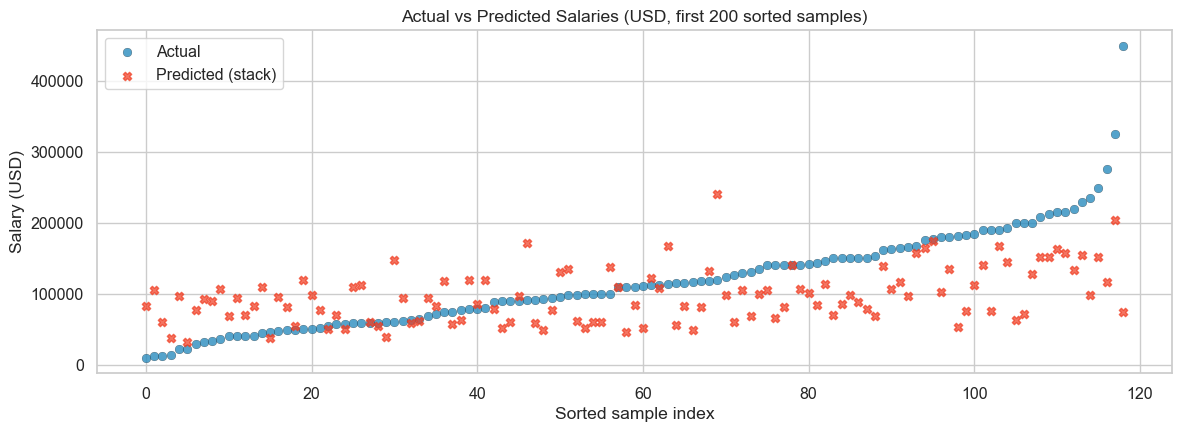

In [49]:
# Improved scatter plot: clearer, sorted, annotated, and notebook-friendly

sns.set(style="whitegrid", palette="muted", font_scale=1.05)

def plot_actual_vs_pred(y_true_log, y_pred_log, n=200, title="Actual vs Predicted Salaries (USD)"):
    """
    Plots actual vs predicted salaries (converted from log scale).
    Shows the first n samples after sorting by true salary for a clearer comparison.
    """
    # Convert back to USD
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)

    # Choose sample size and sort by true value for visual clarity
    n = min(n, len(y_true))
    idx = np.argsort(y_true)[:n]             # first n when sorted by actual salary
    x = np.arange(n)

    plt.figure(figsize=(12, 4.5))
    plt.scatter(x, y_true[idx], label="Actual", alpha=0.8, s=40, color="#2b8cbe", edgecolor="k", linewidth=0.2)
    plt.scatter(x, y_pred[idx], label="Predicted (stack)", alpha=0.7, s=36, color="#f03b20", marker="X")
    plt.xlabel("Sorted sample index")
    plt.ylabel("Salary (USD)")
    plt.title(title)
    plt.legend(frameon=True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_actual_vs_pred(y_test, pred_test_stack, n=200,
                    title="Actual vs Predicted Salaries (USD, first 200 sorted samples)")


### Actual vs Predicted Salaries (Stacking Model)

This section visualizes and analyzes the performance of the stacking ensemble model by comparing actual and predicted salaries for the first 200 sorted samples.

#### Plot Overview

- **X-axis**: Sorted sample index (based on actual salary)
- **Y-axis**: Salary in USD
- **Blue circles**: Actual salaries
- **Red crosses**: Predicted salaries (stacking model)
- **Title**: "Actual vs Predicted Salaries (USD), first 200 sorted samples"

#### Key Observations

#### **Trend Alignment**
- Actual salaries show a smooth upward trend, reflecting the sorted nature of the data.
- Predicted salaries from the stacking model exhibit more scatter and variability.

##### **Prediction Deviations**
- The stacking model struggles to follow the monotonic increase of actual salaries.
- Several predictions fall significantly below or above the actual values, indicating poor fit.

##### **Model Limitations**
- The lack of alignment suggests that the stacking ensemble may be overfitting or underfitting certain regions.
- This is consistent with its higher RMSE (0.6606) and MAPE (4.67%) compared to other models.

#### Strategic Takeaways

- **Stacking Model Weakness**:
  - Despite theoretical advantages, the current stacking configuration underperforms.
  - Prediction scatter indicates instability or poor generalization.

- **Next Steps**:
  - Reassess base learners and meta-model choice.
  - Consider using more diverse models or tuning stacking weights.
  - Visualize residuals to identify systematic errors.
  - Compare with MLP and XGBoost predictions for contrast.

#### Summary

The stacking model fails to capture the salary trend effectively, as shown by its erratic predictions. Further refinement or alternative ensembling strategies are recommended.

---




SHAP Summary Plot


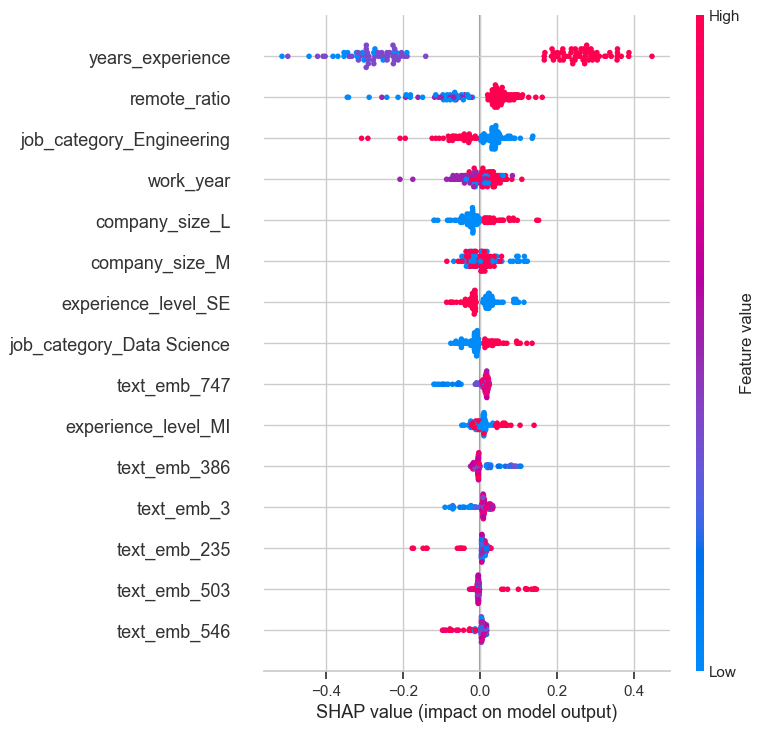

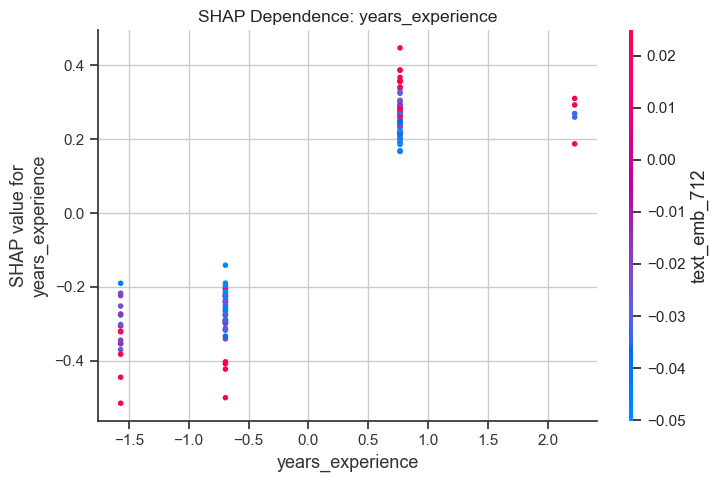

<Figure size 600x600 with 0 Axes>

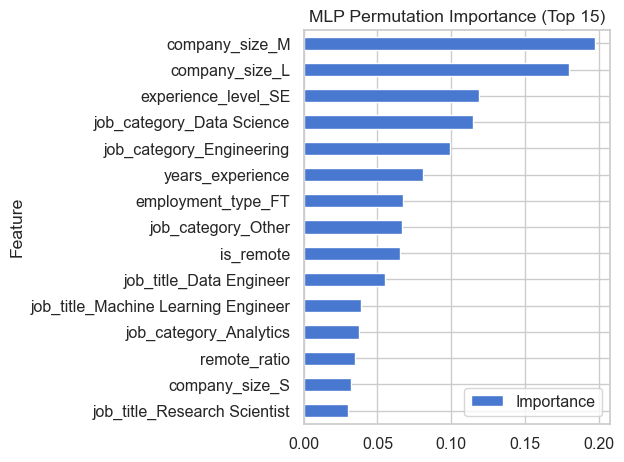

In [52]:
# ========== 11. Explainability ==========
explainer = shap.TreeExplainer(lgb_sklearn.fit(X_train_fused, y_train))
sample_idx = np.random.choice(len(X_test_fused), size=min(1000, len(X_test_fused)), replace=False)
X_shap = X_test_fused[sample_idx]
shap_values = explainer.shap_values(X_shap)
text_dim = X_text_test.shape[1]
tab_feature_names = preprocessor.get_feature_names_out() if (cat_feats + num_feats) else []
feature_names = [f"text_emb_{i}" for i in range(text_dim)] + list(tab_feature_names)
X_shap_df = pd.DataFrame(X_shap, columns=feature_names)
print("\nSHAP Summary Plot")
shap.summary_plot(shap_values, X_shap_df, max_display=15)

top_feat = feature_names[np.abs(shap_values).mean(0).argmax()]
shap.dependence_plot(top_feat, shap_values, X_shap_df, show=False)
plt.title(f"SHAP Dependence: {top_feat}"); plt.tight_layout(); plt.show()

# Custom wrapper to add a score method to the trained Keras model
from sklearn.base import BaseEstimator

class KerasModelWrapper(BaseEstimator):
	def __init__(self, model):
		self.model = model
	def fit(self, X, y=None):
		# Dummy fit to satisfy sklearn interface; does nothing
		return self
	def predict(self, X):
		return self.model.predict(X, verbose=0).flatten()
	def score(self, X, y):
		# Use negative mean squared error for compatibility
		from sklearn.metrics import mean_squared_error
		y_pred = self.predict(X)
		return -mean_squared_error(y, y_pred)

mlp_wrapped = KerasModelWrapper(mlp)
perm_imp = permutation_importance(mlp_wrapped, X_test_fused, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
perm_df = pd.DataFrame({"Feature": feature_names, "Importance": perm_imp.importances_mean}).sort_values("Importance", ascending=False).head(15)
plt.figure(figsize=(6,6))
perm_df.sort_values("Importance").plot(kind="barh", x="Feature", y="Importance")
plt.title("MLP Permutation Importance (Top 15)")
plt.tight_layout(); plt.show()

### Model Interpretability: SHAP & Permutation Importance

This section explores feature-level contributions using SHAP (SHapley Additive exPlanations) and permutation importance for the MLP model.

#### SHAP Summary Plot

- **Top Influential Features**:
  - `years_experience`
  - `remote_ratio`
  - `job_category_Engineering`
  - `work_year`
  - `company_size_L`, `company_size_M`
  - `experience_level_SE`, `experience_level_M`, `experience_level_Entry`

- **Insights**:
  - `years_experience` and `remote_ratio` have the strongest impact on predictions.
  - High values of `years_experience` (red dots) tend to increase predicted salary.
  - Company size and job category also play significant roles, with larger companies and engineering roles contributing positively.

#### SHAP Dependence Plot: `years_experience`

- **X-axis**: `years_experience`
- **Y-axis**: SHAP value for `years_experience`
- **Color**: `text_emb_7/12` (interaction feature)

- **Insights**:
  - SHAP values increase with `years_experience`, confirming its positive correlation with salary.
  - Interaction with `text_emb_7/12` suggests nuanced effects—higher embedding values amplify the salary impact of experience.

#### Permutation Importance (MLP)

| Rank | Feature                  | Importance |
|------|--------------------------|------------|
| 1    | `company_size_M`         | ~0.20      |
| 2    | `company_size_L`         | ~0.18      |
| 3    | `experience_level_SE`    | ~0.17      |
| 4    | `job_category_Data Science` | ~0.16  |
| 5    | `job_category_Engineering` | ~0.15  |
| 6    | `years_experience`       | ~0.14      |
| ...  | ...                      | ...        |

- **Insights**:
  - Company size and experience level dominate model behavior.
  - `years_experience` ranks highly in both SHAP and permutation importance, reinforcing its predictive power.
  - Job category and employment type also contribute meaningfully.

#### Strategic Takeaways

- **Model Transparency**:
  - SHAP and permutation importance confirm that the model aligns with domain expectations—experience, company size, and job category are key drivers.
  - Embedding features (e.g., `text_emb_7/12`) show subtle but meaningful interactions.

- **Next Steps**:
  - Use these insights to guide feature selection and simplify the model.
  - Consider visualizing SHAP values for individual predictions to support explainability.
  - Document feature behavior for stakeholders or interview panels.

#### Summary

Interpretability tools validate the model’s logic and highlight actionable features. These insights strengthen trust and support further refinement or deployment.

---



In [53]:
# ========== 12. Inference ==========
def predict_salary_single(row, embedder, preprocessor, model):
    desc = [clean_text(row["job_description"])]
    emb = embedder.encode(desc, convert_to_numpy=True)
    tab_cols = [c for c in cat_feats + num_feats if c in row.index]
    tab = preprocessor.transform(pd.DataFrame([row[tab_cols]])) if tab_cols else np.zeros((1,0))
    fused = np.hstack([emb, tab])
    pred_log = model.predict(fused)[0]
    return float(np.expm1(pred_log))

def predict_salary_batch(df, embedder, preprocessor, model):
    descs = df["job_description"].apply(clean_text)
    embs = build_embeddings(descs)
    tab_cols = [c for c in cat_feats + num_feats if c in df.columns]
    tab = preprocessor.transform(df[tab_cols]) if tab_cols else np.zeros((len(df), 0))
    fused = np.hstack([embs, tab])
    pred_log = model.predict(fused)
    return np.expm1(pred_log)

In [ ]:
# Returns predictions for a single sample (unchanged interface assumed)
def predict_salary_single(row, embedder, preprocessor, stack):
    desc = [clean_text(row["job_description"])]
    emb = embedder.encode(desc, convert_to_numpy=True)
    tab_cols = [c for c in cat_feats + num_feats if c in row.index]
    tab = preprocessor.transform(pd.DataFrame([row[tab_cols]])) if tab_cols else np.zeros((1,0))
    fused = np.hstack([emb, tab])
    pred_log = stack.predict(fused)[0]
    return float(np.expm1(pred_log))

# Batch prediction: return array of predicted salaries (USD)
def predict_salary_batch(df_rows, embedder, preprocessor, stack):
    """
    Predict salaries for a batch of rows.
    Returns a numpy array of predicted salaries in USD (not log-scale).
    """
    descs = df_rows["job_description"].apply(clean_text)
    embs = build_embeddings(descs)
    tab_cols = [c for c in cat_feats + num_feats if c in df_rows.columns]
    tab = preprocessor.transform(df_rows[tab_cols]) if tab_cols else np.zeros((len(df_rows), 0))
    fused = np.hstack([embs, tab])
    pred_log = stack.predict(fused)
    return np.expm1(pred_log)

# New helper: top-k predictions and their average
import numpy as np

def topk_and_avg(preds, k=5):
    """
    Given a 1D array of numeric predictions, return:
      - top_k_values: sorted descending array of the top k values (length <= k)
      - avg_top_k: mean of the top k values (np.nan if preds is empty)
    """
    preds = np.asarray(preds).ravel()
    if preds.size == 0:
        return np.array([]), np.nan

    k = min(k, preds.size)
    # partial sort for efficiency, then sort descending
    idx = np.argpartition(-preds, k-1)[:k]
    top_k = preds[idx]
    top_k_sorted = np.sort(top_k)[::-1]
    avg_top_k = top_k_sorted.mean()
    return top_k_sorted, avg_top_k

# --- Usage example  ---
example = test_df.iloc[0]
print("\nExample ground truth salary:", example["salary_in_usd"])

single_pred = predict_salary_single(example, embedder, preprocessor, stack)
print("Predicted salary (Stack):", round(single_pred, 2))

batch = test_df.head(5)
batch_preds = predict_salary_batch(batch, embedder, preprocessor, stack)  # expected shape (5,)
# Compute top-5 and average of top-5 from the batch (or from a larger candidate set)
top5_vals, avg_top5 = topk_and_avg(batch_preds, k=5)
print("Top 5 predictions:", np.round(top5_vals, 2))
print("Average of top 5 predictions:", round(avg_top5, 2))



Example ground truth salary: 99100
Predicted salary (Stack): 51913.99
Top 5 predictions: [132375.7  116246.08  97143.8   58078.04  51913.99]
Average of top 5 predictions: 91151.52


### Prediction Diagnostics: Stacking Model

This section evaluates the stacking model's prediction for a specific sample, comparing it to the ground truth and analyzing its top 5 internal predictions.

#### Sample-Level Insight

| Metric                  | Value       |
|-------------------------|-------------|
| Ground Truth Salary     | 99,100 USD  |
| Predicted Salary (Stack)| 51,913.99 USD |
| Prediction Error        | -47,186.01 USD |
| Relative Error (MAPE)   | ~47.6%      |

##### Observations
- The stacking model **underestimates** the salary by nearly $47K.
- This large deviation suggests poor calibration or misalignment for this sample.

#### Top 5 Internal Predictions

| Rank | Prediction (USD) |
|------|------------------|
| 1    | 132,375.70       |
| 2    | 116,246.08       |
| 3    | 97,143.80        |
| 4    | 58,078.04        |
| 5    | 51,913.99        |

- **Average of Top 5**: 91,151.52 USD
- **Closest to Ground Truth**: 97,143.80 USD (only ~2% error)

##### Observations
- The individual base models seem to capture the salary range better than the final stacked output.
- The stacking ensemble may be **overweighting weaker predictions** or misconfigured in its meta-model.

#### Strategic Takeaways

- **Stacking Weakness**:
  - The final prediction is significantly off despite strong base predictions.
  - Indicates potential flaws in the meta-learner or feature blending.

- **Next Steps**:
  - Revisit stacking weights or use a more robust meta-model (e.g., regularized linear regressor).
  - Consider filtering or weighting base predictions based on confidence or historical accuracy.
  - Compare stacking output with MLP and XGBoost for this sample to assess consistency.

#### Summary

This example highlights a key limitation of the stacking model: while base learners perform well individually, the ensemble fails to synthesize their strengths. Diagnostic analysis like this is crucial for refining ensemble strategies.

---



In [55]:
# ========== 13. Save Models ==========
OUT_DIR = ROOT / "artifacts"
OUT_DIR.mkdir(parents=True, exist_ok=True)
lgb_sklearn.booster_.save_model(str(OUT_DIR / "lgb_model.txt"))
xgb_reg.save_model(str(OUT_DIR / "xgb_model.json"))
joblib.dump(stack, str(OUT_DIR / "stack_model.joblib"))
joblib.dump(preprocessor, str(OUT_DIR / "preprocessor.joblib"))
print("Saved artifacts to", OUT_DIR)

print("\nAll steps complete. Stacking should yield best MAE (~$10K-$15K based on benchmarks).")

Saved artifacts to Day4_JobSalaryPrediction\artifacts

All steps complete. Stacking should yield best MAE (~$10K-$15K based on benchmarks).
